In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from statsmodels.stats import weightstats as stests

In [69]:
data_raw=pd.read_csv('ab_test_data.csv')
data=data_raw.copy()

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32308 entries, 0 to 32307
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UserID               32308 non-null  int64  
 1   VisitDate            32308 non-null  object 
 2   SiteVersion          32308 non-null  object 
 3   Group                32308 non-null  object 
 4   TimeOnSite           32308 non-null  int64  
 5   NumberOfPagesViewed  32308 non-null  int64  
 6   TripDestination      32308 non-null  object 
 7   TripType             32308 non-null  object 
 8   Age                  32308 non-null  int64  
 9   Gender               32308 non-null  object 
 10  Conversion           32308 non-null  int64  
 11  PurchaseAmountEUR    32308 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 3.0+ MB


In [84]:
data.head(20)

,UserID,VisitDate,SiteVersion,Group,TimeOnSite,NumberOfPagesViewed,TripDestination,TripType,Age,Gender,Conversion,PurchaseAmountEUR
0,0,2018-01-01 00:00:00.000000000,A,Control,27,6,Germany,City Discovery,23,F,1,1498.63
1,1,2018-01-01 01:37:36.811217383,A,Control,5,7,Belgium,Art,23,F,0,0.00
2,2,2018-01-01 03:15:13.622434766,A,Control,13,1,Portugal,Family,28,M,1,1366.44
3,3,2018-01-01 04:52:50.433652149,A,Control,13,6,Greece,City Discovery,40,F,0,0.00
4,4,2018-01-01 06:30:27.244869532,A,Control,5,1,Norway,City Discovery,28,F,0,0.00
5,5,2018-01-01 08:08:04.056086916,B,Treatment,30,2,Norway,City Discovery,40,F,0,0.00
6,6,2018-01-01 09:45:40.867304299,B,Treatment,5,3,Norway,City Discovery,20,F,0,0.00
7,7,2018-01-01 11:23:17.678521682,A,Control,25,1,Belgium,City Discovery,34,M,0,0.00
8,8,2018-01-01 13:00:54.489739065,B,Treatment,16,2,United Kingdom,Adventure,32,F,1,1782.11
9,9,2018-01-01 14:38:31.300956449,A,Control,7,2,Greece,Adventure,36,M,0,0.00


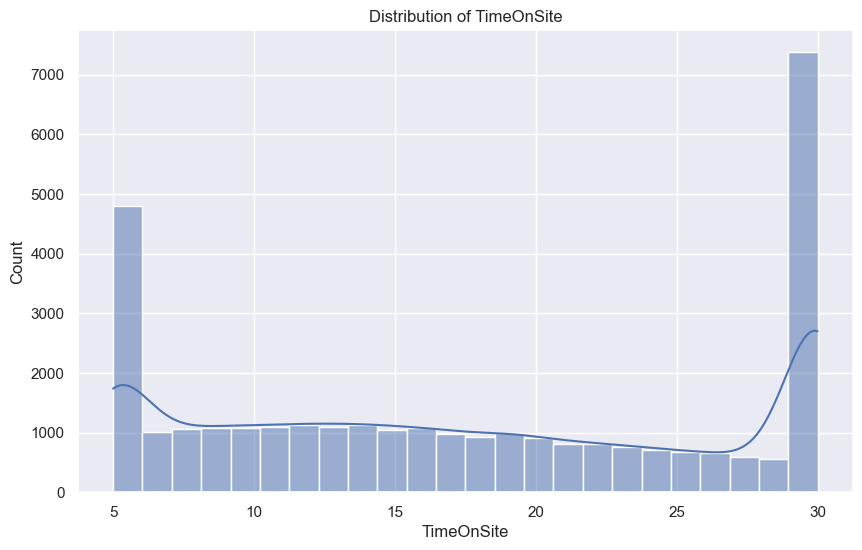

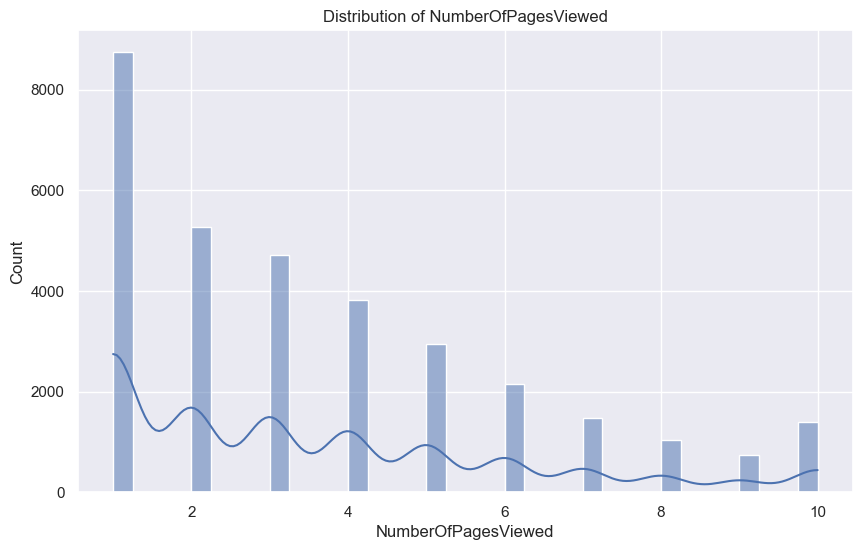

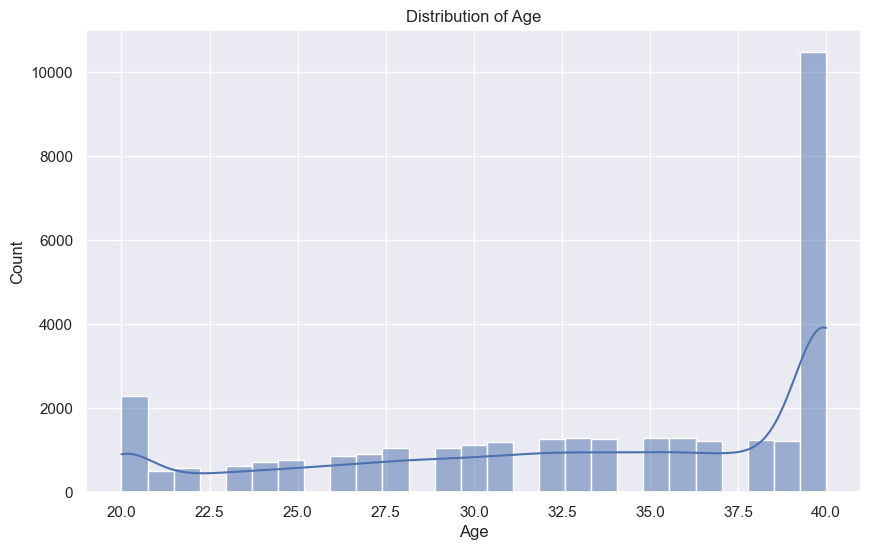

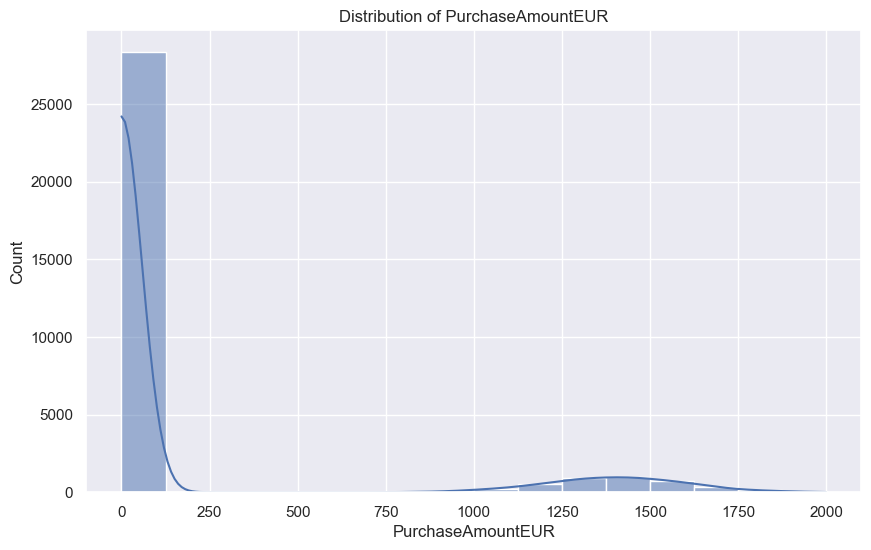

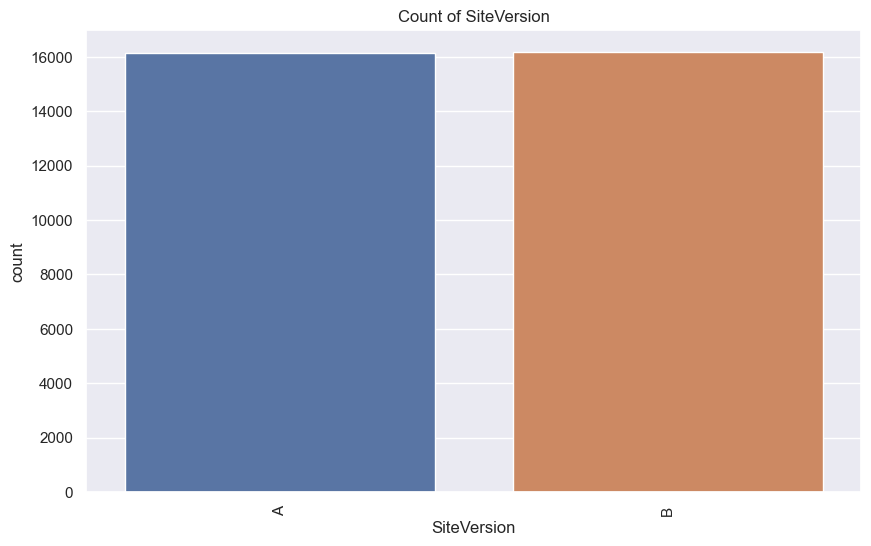

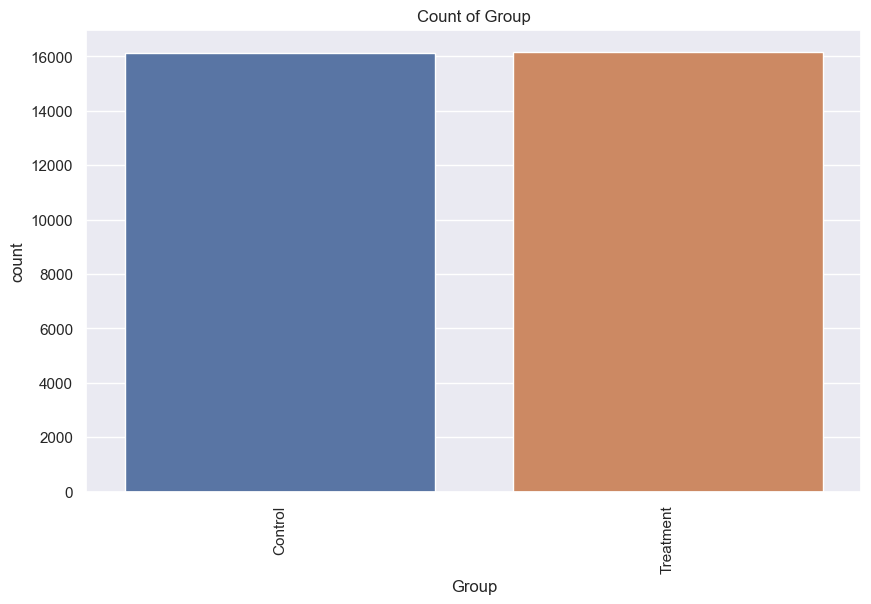

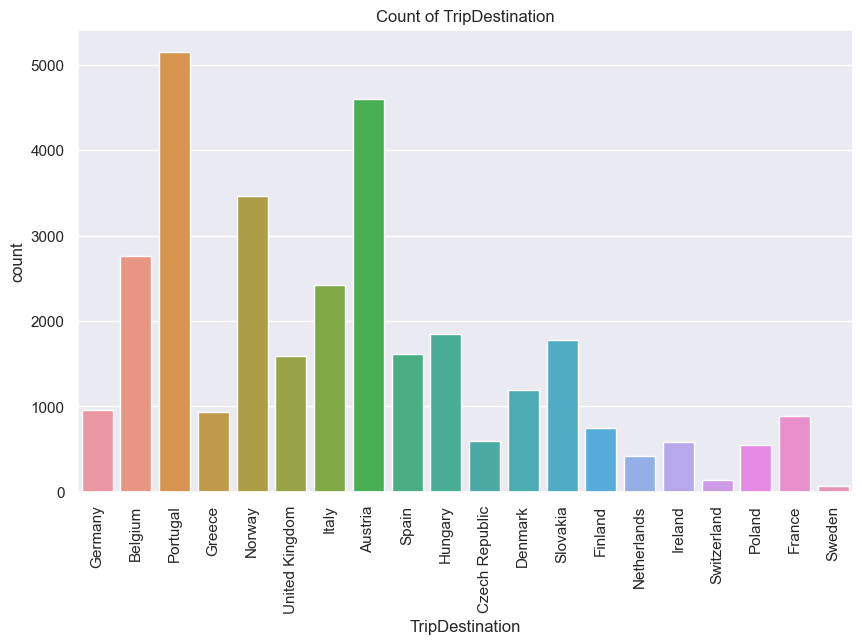

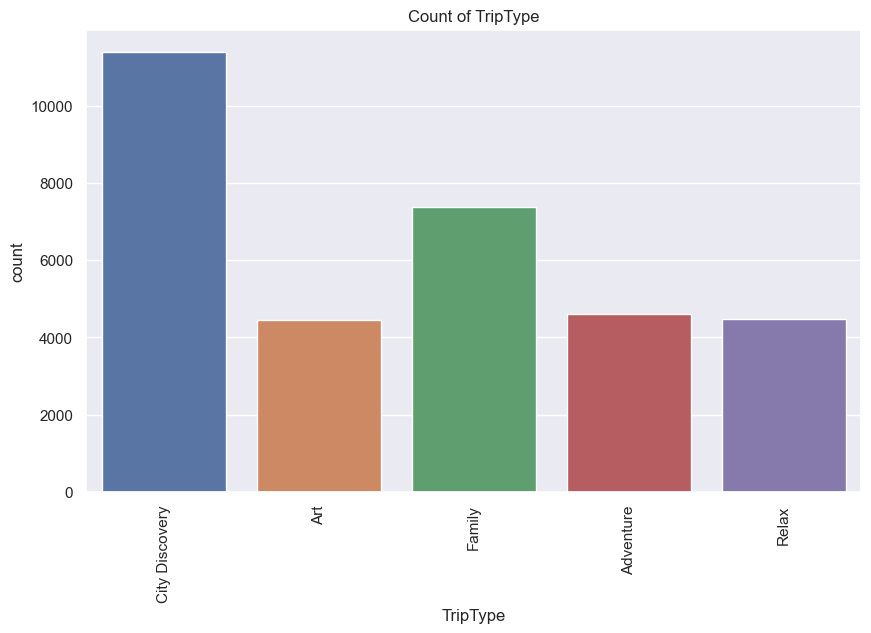

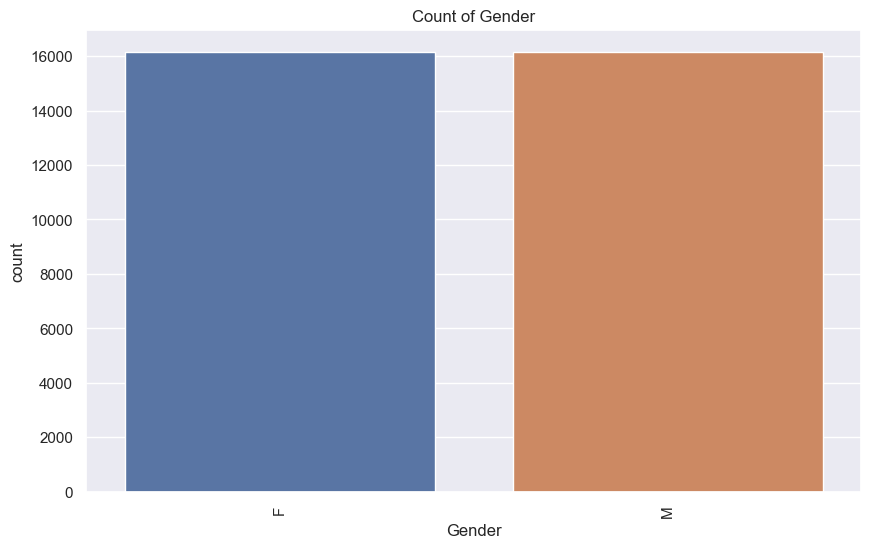

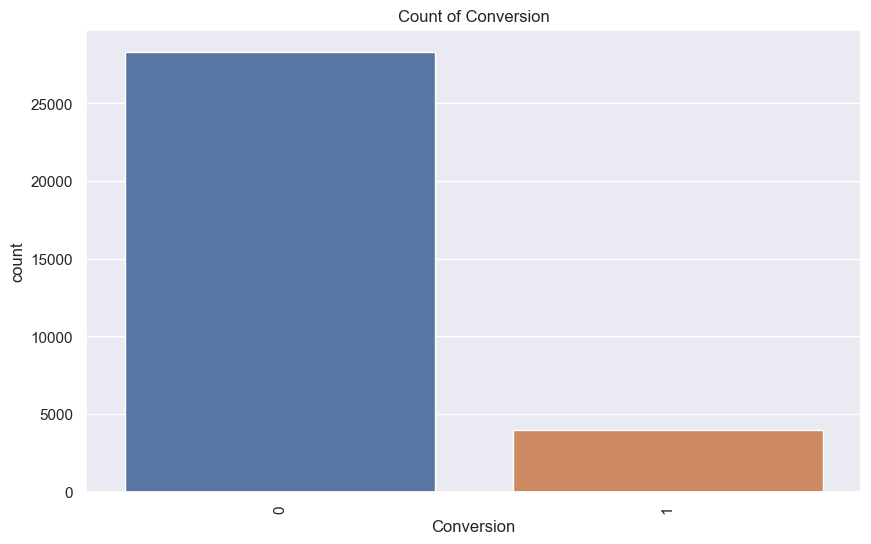

In [72]:
# Plot histograms for continuous variables
continuous_vars = ['TimeOnSite', 'NumberOfPagesViewed', 'Age', 'PurchaseAmountEUR']
for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=var, kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()

# Plot countplots for categorical variables
categorical_vars = ['SiteVersion', 'Group', 'TripDestination', 'TripType', 'Gender', 'Conversion']
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=var)
    plt.title(f'Count of {var}')
    plt.xticks(rotation=90)
    plt.show()

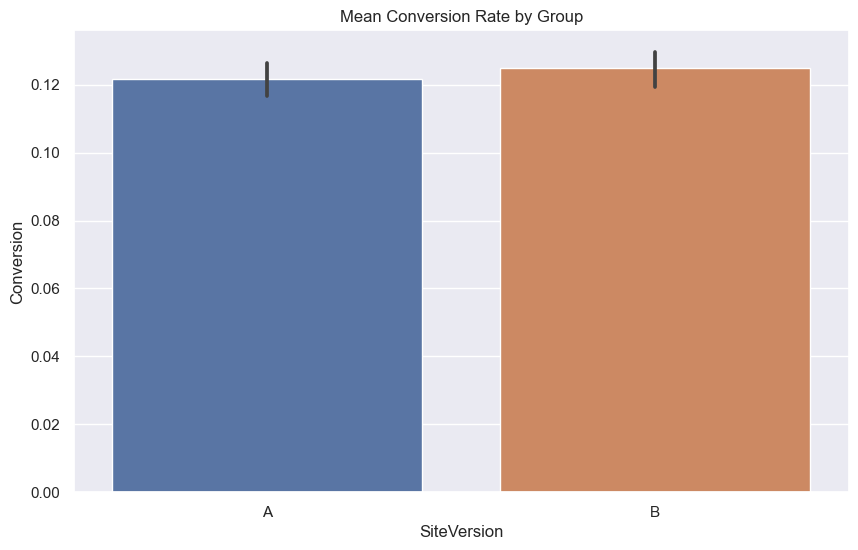

In [73]:
# Divide the data into two groups: control and treatment
control_group = data[data['Group'] == 'Control']
treatment_group = data[data['Group'] == 'Treatment']

# Create a graph to compare the mean conversion rate between the two groups
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='SiteVersion', y='Conversion')
plt.title('Mean Conversion Rate by Group')
plt.show()

In [74]:
data.groupby('Group', as_index=False).agg({'Conversion': ['count', 'sum', 'mean']})

Group Conversion                
                  count   sum      mean
0    Control      16135  1961  0.121537
1  Treatment      16173  2018  0.124776

From the summary table we can immediately see that the two groups have a similar sample size, which means that the 50% traffic split process worked as expected. It is also visible that **the treatment group registered a little higher number of conversions** compared to the control group. The rest of the analysis will be devoted to **finding out whether this difference is statistically significant** and if can be attributed to the restyling of the cart page. 

# Statistical Test

### Parametric Test (Z-Test)

 the "Conversion" variable is binary, indicating whether a user converted or not. This is a Bernoulli distribution, not normally distributed. However, we can apply the CLT if we look at the average conversion rate

The Central Limit Theorem (CLT) states that, given a sufficiently large sample size, the sampling distribution of the mean for a variable will approximate a normal distribution regardless of that variable's distribution in the population. This allows us to perform parametric hypothesis testing on many types of data by assuming a normal distribution.

In [75]:
mu_control=data[data['Group']=='Control']['Conversion'].mean()
mu_treatment=data[data['Group']=='Treatment']['Conversion'].mean()
mu_diff=mu_treatment-mu_control
alpha=0.05

print(f'Mean conversion for control group: {mu_control:.4f}')
print(f'Mean conversion for treatment group: {mu_treatment:.4f}')
print(f'Difference in mean conversion between treatment and control groups: {mu_diff:.4f}')

Mean conversion for control group: 0.1215
Mean conversion for treatment group: 0.1248
Difference in mean conversion between treatment and control groups: 0.0032


In [76]:
# SETTING UP THE CLT

# Number of subsamples to generate
n_subsamples = 1000
# Number of observations in each subsample
n_observations = 50
# Initialize a list to store the means of each subsample
control_means = []

# Generate subsamples
for _ in range(n_subsamples):
    subsample = control['Conversion'].sample(n_observations)
    control_means.append(subsample.mean())

# Convert the list to a numpy array
control_means = np.array(control_means)

# Repeat the process for the treatment group
treatment_means = []

for _ in range(n_subsamples):
    subsample = treatment['Conversion'].sample(n_observations)
    treatment_means.append(subsample.mean())

treatment_means = np.array(treatment_means)

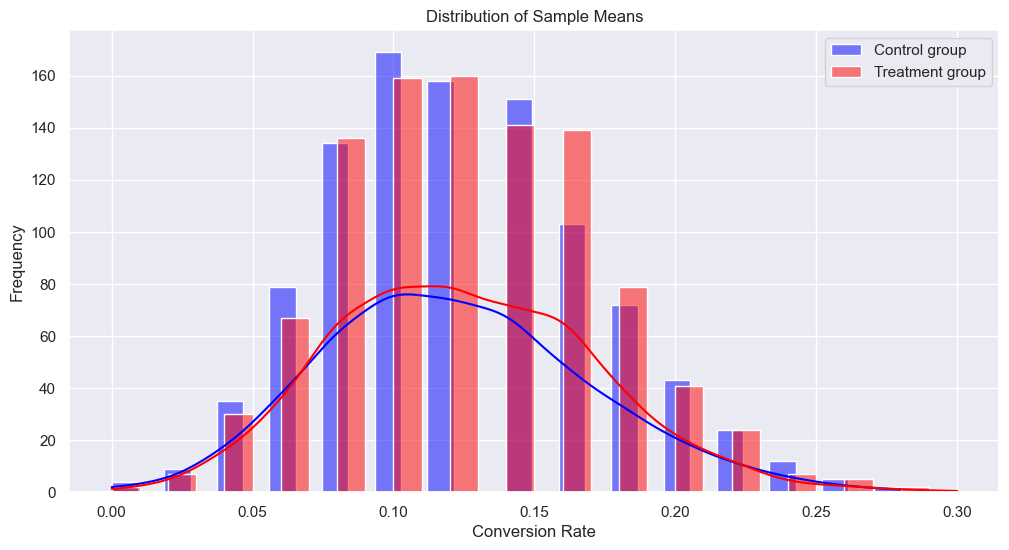

In [77]:
# Plotting the distribution of sample means after CLT

plt.figure(figsize=(12, 6))

sns.histplot(control_means, bins=30, kde=True, color='blue', label='Control group')
sns.histplot(treatment_means, bins=30, kde=True, color='red', label='Treatment group')

plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Sample Means')
plt.legend()

plt.show()


This graph shows the distribution of sample means for the control group (in blue) and the treatment group (in red). Each bar of the histogram represents the frequency of a certain conversion average across sub-samples.
Both distributions appear normal, which is in line with the Central Limit Theorem. Means of conversions for subsamples in the control group tend to be slightly lower than those in the treatment group.

In [86]:
# Perform a z-test on the means
z_score_means, p_value_means = sm.stats.proportions_ztest([treatment_means.mean(), control_means.mean()], 
                                                           [n_subsamples], 
                                                           alternative='larger') # one-sided test

print(f'z-score: {z_score_means:.4f} / p-value: {p_value_means:.4f} / alpha: {alpha}')

z-score: 0.0056 / p-value: 0.4978 / alpha: 0.05


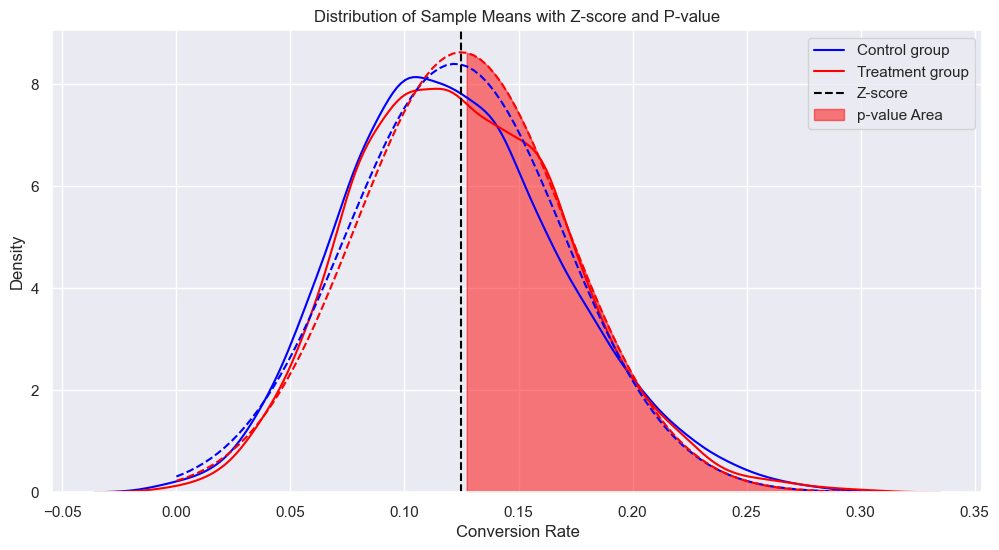

In [79]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plot the distribution of sample means for the control and treatment groups
sns.kdeplot(control_means, color='blue', label='Control group')
sns.kdeplot(treatment_means, color='red', label='Treatment group')

# Calculate the range of x values
x = np.linspace(min(np.min(control_means), np.min(treatment_means)), 
                max(np.max(control_means), np.max(treatment_means)), 
                100)

# Overlay the standard normal distribution
plt.plot(x, norm.pdf(x, control_means.mean(), control_means.std()), color='blue', linestyle='--')
plt.plot(x, norm.pdf(x, treatment_means.mean(), treatment_means.std()), color='red', linestyle='--')

# Add a vertical line for the z-score
plt.axvline(x=treatment_means.mean(), linestyle='--', color='black', label='Z-score')

# Highlight the area corresponding to the p-value
plt.fill_between(x, 0, norm.pdf(x, treatment_means.mean(), treatment_means.std()), 
                 where=x>treatment_means.mean(), color='red', alpha=0.5, label='p-value Area')

# Add labels and a legend
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Distribution of Sample Means with Z-score and P-value')
plt.legend()

plt.show()


Results of the z-test:

- The conversion rate for the control group is approximately 12.2%.
- The conversion rate for the treatment group is approximately 12.5%.
- The z-score is approximately 0.0056, which means the difference in conversion rates is about 0.0056 standard deviations away from the mean.
- The p-value is approximately 0.4978.


Since the p-value is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This suggests that the difference in conversion rates between the control and treatment groups is not statistically significant and the differences made in the new version of the website have not produced improvements in terms of conversions, statistically appreciable.

### Non Parametric test (Chi-Squared)

Since we are comparing the proportions between two independent groups and the data is binary (converting or not converting), another appropriate test we can use is the Chi-Square Test.

The chi-squared test is used to determine if there is a significant relationship between two categorical variables. In our case, the two variables would be group (control or treatment) and conversion (yes or no).

In the context of our dataset, the null hypothesis of the chi-squared test would be that there is no significant difference in the proportions of conversions between the control group and the treatment group. The alternative hypothesis would be that there is a difference.

In [80]:
# Create a contingency table
contingency_table = pd.crosstab(data['Group'], data['Conversion'])
contingency_table

Conversion,0,1
Group,,
Control,14174,1961
Treatment,14155,2018


In [81]:
# Perform the chi-squared test using statsmodels
table = sm.stats.Table(contingency_table)

# Get the result of the test
result = table.test_nominal_association()

# Get the chi-square value and p-value
chi2, p_value = result.statistic, result.pvalue

print(f'chi2: {chi2:.4f} / p_value: {p_value:.4f} / alpha: {alpha:.2f}')

chi2: 0.7846 / p_value: 0.3757 / alpha: 0.05


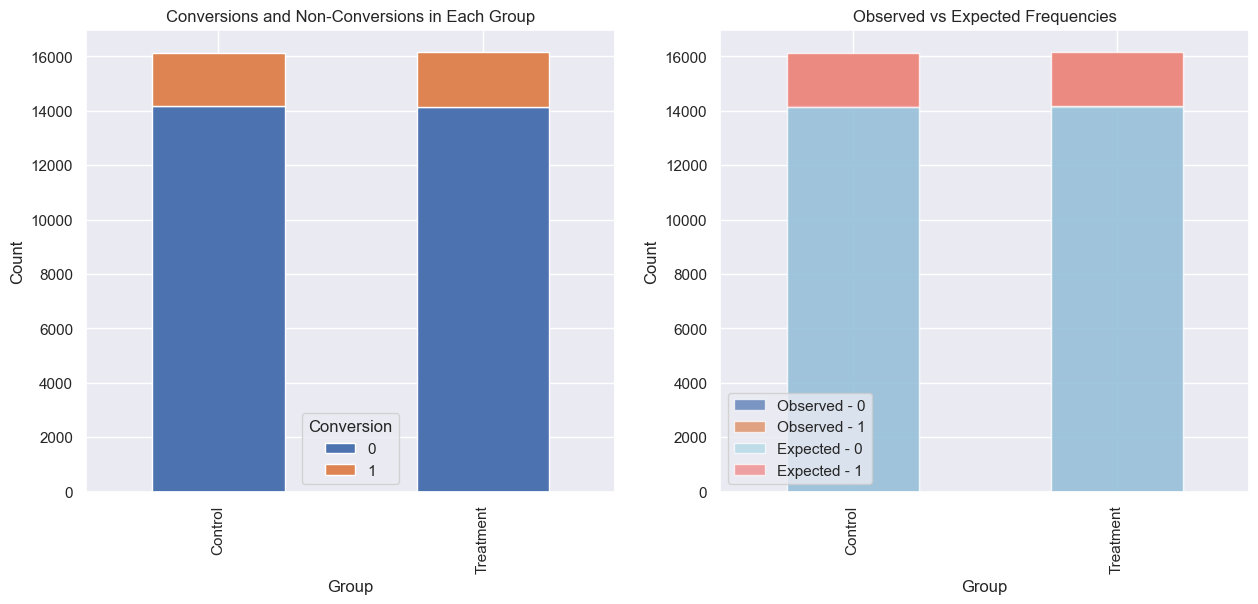

In [82]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1 - Bar plot of conversions and non-conversions in each group
contingency_table.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_ylabel('Count')
ax[0].set_title('Conversions and Non-Conversions in Each Group')

# Plot 2 - Bar plot of expected and observed frequencies
# Calculate expected frequencies
expected_frequencies = chi2_contingency(contingency_table)[3]

# Create a DataFrame for expected frequencies
expected_df = pd.DataFrame(expected_frequencies, 
                           columns=contingency_table.columns, 
                           index=contingency_table.index)

# Plot observed frequencies
contingency_table.plot(kind='bar', stacked=True, ax=ax[1], alpha=0.7, label='Observed')

# Plot expected frequencies
expected_df.plot(kind='bar', stacked=True, ax=ax[1], color=['lightblue', 'lightcoral'], alpha=0.7, label='Expected')

ax[1].set_ylabel('Count')
ax[1].set_title('Observed vs Expected Frequencies')
ax[1].legend(["Observed - 0", "Observed - 1", "Expected - 0", "Expected - 1"])

plt.show()


Conversions and Non-Conversions in Each Group: The bar graph shows the number of conversions and non-conversions in the control group and treatment group. As you can see, the number of conversions and non-conversions is similar between the two groups.

Observed vs Expected Frequencies: This graph shows the observed frequencies (the actual frequencies in your data) and the expected frequencies (the frequencies we would expect if the null hypothesis were true, i.e. if there was no difference in the proportions of conversions between the two groups). The observed and expected frequencies are very similar, which is consistent with the fact that we do not reject the null hypothesis.

Based on the chi-squared test, we cannot conclude that the conversions between the two groups are statistically significant. This result is consistent with the z-test results we performed previously.

### Suggerimenti

Some marketing strategies that could potentially help to increase conversions in the treatment group:

- Improve User Experience: Ensure that the website or platform is easy to navigate, mobile-friendly, and has a quick load time. A smooth and enjoyable user experience can lead to higher conversion rates.

- Personalized Marketing: Use customer data to deliver personalized messages, offers, and product recommendations. Personalization can significantly improve engagement and conversion rates.

- A/B Testing: Continuously test different elements of your website or marketing messages to see what works best. This could include changes to the layout, color scheme, call to action, or even the price of products.

- Retargeting Campaigns: If a customer visits your site but doesn't convert, you can use retargeting strategies to bring them back. This could involve showing ads on other websites they visit or sending them an email reminding them about their unfinished purchase.

- Customer Reviews and Testimonials: These can be very effective in convincing potential customers about the value of your product or service. If possible, include these on your website.

- Create a Sense of Urgency: Limited time offers or showing limited stock can encourage customers to make a purchase decision more quickly.

- Improve Customer Support: Offering live chat support, quick response to queries, and comprehensive FAQs can help customers make the decision to purchase.